# Nanodegree Engenheiro de Machine Learning
## Projeto final
### Classificação de áudio por gêneros musicais
Paulo Leonardo Vieira Rodrigues  
10 de maio de 2018



## I. Definição

### Visão geral do projeto

<p>A música (do grego μουσική τέχνη - musiké téchne, a arte das musas) é uma a atividade
humana que remonta há séculos, principalmente para entretenimento, é uma mistura de
sons e ritmos, e não há nenhuma organização humana onde ela não esteja presente.
Nos dias atuais, a música pode ser dividida e classificada em diferentes gêneros
musicais, e de forma geral, os seres humanos conseguem identificar e classificar bem
uma música por gênero apenas à ouvindo. </p>

<p> Neste sentido, machine learning tem sido aplicado muitas vezes na tarefa de permitr
que máquinas consigam realizar esse processo, que é inerente aos humanos, seja em
classificação automática por gênero músical, sistema de recomendações musicais,
estruturação organizacional automática de arquivos de música, entre outros. Estudos
como o realizados por Tzanetakis[1] exploram o machine learning aplicado à
classificação musical por gênero onde são demonstrados, por exemplo, as ligações entre
instrumentação, ritmo e harmonia.</p>

<p> Para alcançarmos esse objetivo, antes de mais nada, precisamos saber como extrair as
features corretas e compreender o que é relevante observar em uma música, ou seja,
como fazer para que um computador entenda o que um arquivo musical representa e
então propor um modelo que seja capaz de realizar tal classificação. Portanto, este
trabalho tenta resolver essa questão.</p>


### Descrição do problema

O objetivo deste projeto é resolver o problema de classificação automática por
gênero musical, ou seja, dado um determinado arquivo de música já previamente
tratado, um algoritmo de aprendizado supervisionado tentará predizer a qual gênero
musical este arquivo pertence. O projeto será restrito aos gêneros rock, pop, jazz,
clássico e blues.

1. Conjuntos de dados e entradas
Este projeto utilizará os datasets da coleção GTZAN [1], que consiste de 100 amostras
de áudio por gênero musical. Cada amostra é constituída por 30 segundos de áudio com
frequência de 22050 Hz Mono 16-bits. Os datasets estão amplamente espalhados na
internet, e podem ser ob dos através de vários repositórios[2]. O dataset é público, 
tendo sido utilizado em muitos trabalhos nesse campo de estudos. Os arquivos já se 
encontram no formato wav, o que é desejado, pois há uma variedade de bibliotecas python 
disponíveis para tratar esse tipo de arquivo bem como uma boa documentação de uso.

2. Extração das features
Deste dataset pretende-se extrair as features chamadas Timbre features, pois são
utilizadas para diferenciar misturas de sons que têm ritmos e tons semelhantes, das
quais iremos utilizar a MFCCS (Mel-frequency Cepstral Coefficients) que é uma feature
bem conhecida e representa, a grosso modo, a capacidade do ser humano distinguir ou
perceber os diferentes pos de sons, ZCR (Zero-crossing rate) que é número de vezes
que um sinal passou pelo o ponto zero, geralmente utilizado para detectar sons
percussivos e também pode indicar a quantidade de ruído de um som,
STE (Short-Term Energy), que é uma medida que pode iden ficar segmentos sonoros ou
não sonoros, RMS (Root mean square) que é a medida da onda de energia num período
de tempo, ou seja, o volume ou intensidade de uma faixa e aqui será u lizado para
detectar as fronteiras entre sinais de fala e música, e por fim, SC (Spectrum Centroid)
que indica onde o “centro de massa” do espectro está localizado e na prática costuma
ser usado como medida do timbre musical.

### Métricas

Como todos os cinco gêneros têm a mesma quantidade de amostras, não há
necessidade de considerar o desequilíbrio dos dados. Portanto, a principal medida que
iremos usar é a acuracidade. Além da acuracidade, também usaremos a matriz de
confusão para ter uma visão direta do desempenho de todas as classes, 

acuracidade = verdadeiros positivos + verdadeiros negativos / Número de todas as amostras

## II. Análise

### Exploração dos dados

O dataset GTZAN é um dataset que contém uma coleção musical dividida em dez gêneros musicais Blues, Classical, Country, Disco, Hiphop, Jazz, Metal, Pop, Reggae e Rock). Cada gênero apresenta 100 amostras de áudios com 30 segundos de duração. Abaixo podemos ver uma representação gráfica de uma amostra por gênero que utilizaremos neste trabalho


In [1]:
%matplotlib inline
%pylab inline

import os
import seaborn as sns
import pandas as pd

from helpers import files, plots
from genre import Genre
from feature import SoundFeature
from helpers import npdata
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler




Populating the interactive namespace from numpy and matplotlib


Plotar as formas de onda de cada gênero musical.Os exemplos são escolhidos de forma "aleatória" para cada gênero. <br>Exemplo:
    1. Blues:1.wav
    2. Classical: 2.wav
    3. Jazz: 3.wav
    4. Pop: 4.wav
    5. Rock: 5.wav
    
Abaixo plotamos o gráfico da forma de onda de cada um dos nossos *samples* para uma visualização inicial de como as formas de ondas se diferenciam em cada gênero.

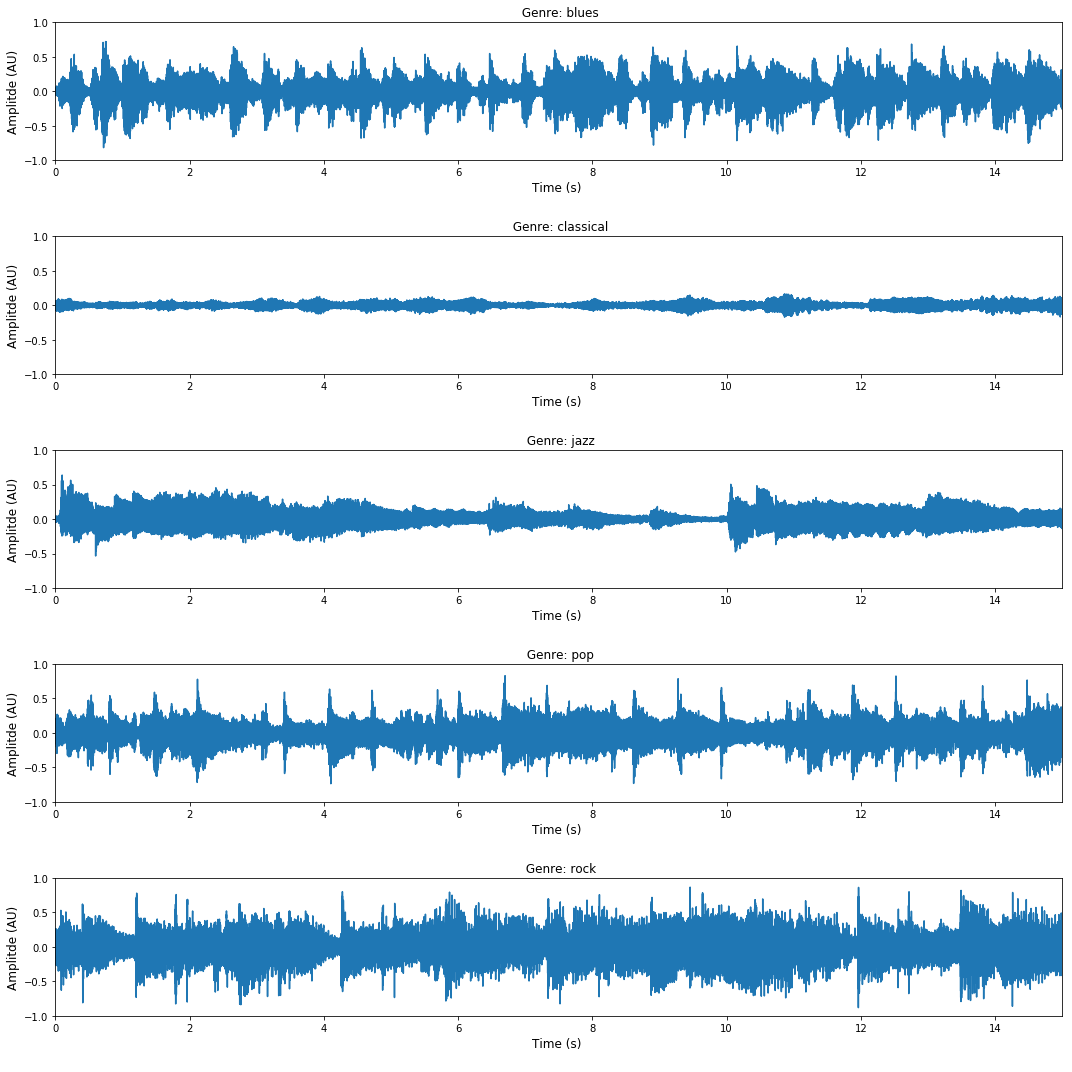

In [2]:
waveform = []
for index, g in enumerate(Genre):
    wf = os.path.join(files.music_path(g.name.lower()), str(index+1) + ".wav")
    waveform.append(wf)
    
plots.plot_wavesform(waveform, n_seconds=15)

### Visualização exploratória

Um dos recursos mais faceis de ser acessado no estudo dos sons são os sinais chamados de amplitude. Eles equilibram e controlam o volume dos sons. Utilizando um gráfico de caixa podemos visualizar melhor como ocorre a variação de amplitude em cada gênero musical. No gráfico abaixo plotamos o gráfico inter-quartil (Q3-Q1) de cada gênero musical.

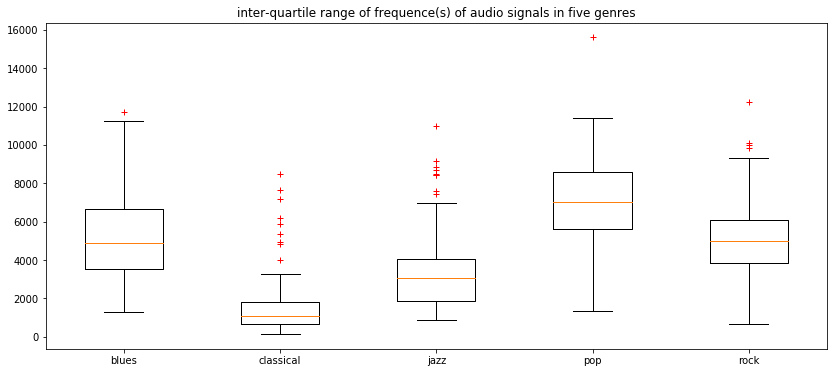

In [3]:
genres = ['blues', 'classical', 'jazz', 'pop', 'rock']

main_dir = files.music_path("")
df = npdata.populate_dataframe(main_dir, duration=15)

plots.plot_iqr(df, genres, SoundFeature.FREQUENCE)

Podemos observar que cada gẽnero musical apresenta uma variação distinta de amplitude. Músicas clássicas apresentam uma menor variação na amplitude musical, enquanto pop apresenta a maior variação dentro das cinco categorias. No entanto, a amplitude por si só não nos assegura um comportamento padrão, pois diferentes estilos musicais podem ter padrões de amplitude similar. Sendo assim, precisamos extrair mais features.

### Algoritmos e técnicas

Nesta seção iremos tratar da extração das features e mostrar algumas técnicas. De forma geral a extração da features é efetuada através da biblioteca python chamada librosa[6], que é uma biblioteca escrita em python para realizar análises de aúdio. Ao utilizar esta biblioteca não precisamos implementar os algoritmos matemáticos para realizar a extração das features que utilizaremos neste trabalho, pois a biblioteca os implementa.

**1) Zero-crossing rate - ZCR**: <br>
Indica número de vezes que um sinal passou pelo o ponto zero, geralmente utilizado para detectar sons
percussivos e também pode indicar a quantidade de ruído de um som. Esta feature é definida pela seguinte equação:

![ZCR](zcr.png)

Aqui exibimos o gráfico da ZCR sobreposto ao gráfico da forma de onda da música. Como podemos ver, cada gênero, representado por uma canção, apresenta uma curva própria no frame que utilizamos.

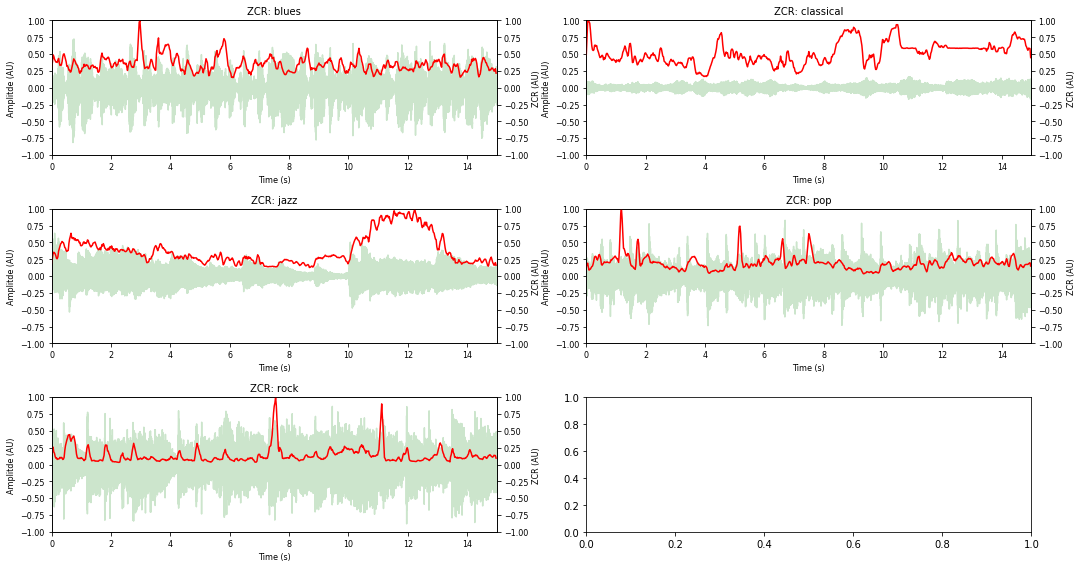

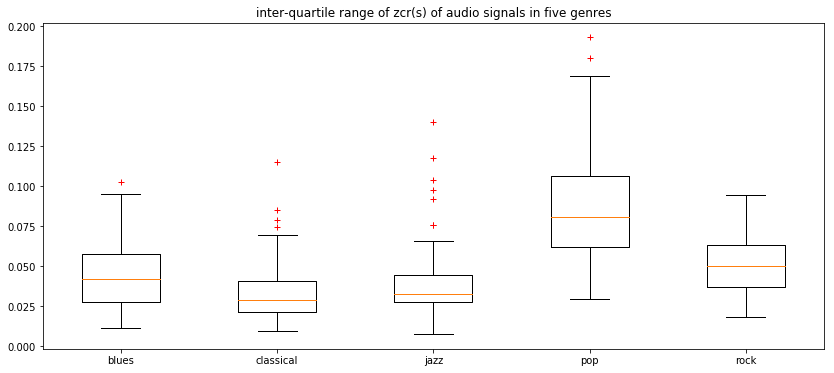

In [4]:
plots.plot_superimprose_wave(waveform, SoundFeature.ZCR,15)
plots.plot_iqr(df, genres, SoundFeature.ZCR)

**2) Root mean square - RMS**:<br>
Indica a medida da onda de energia num período de tempo, ou seja, o volume ou intensidade de uma faixa onde pegamos um seus valores e calculamos a raiz quadrada da média ao quadro. Aqui será utilizado para detectar as fronteiras entre sinais de fala e música, ou a sonoridade da música. Está feature é definida pela seguinte equação:

![RMS](rms.png)

Aqui exibimos o gráfico do RMS sobreposto ao gráfico da forma de onda da música. Como podemos ver, cada gênero, representado por uma canção, apresenta uma curva própria no frame que utilizamos.

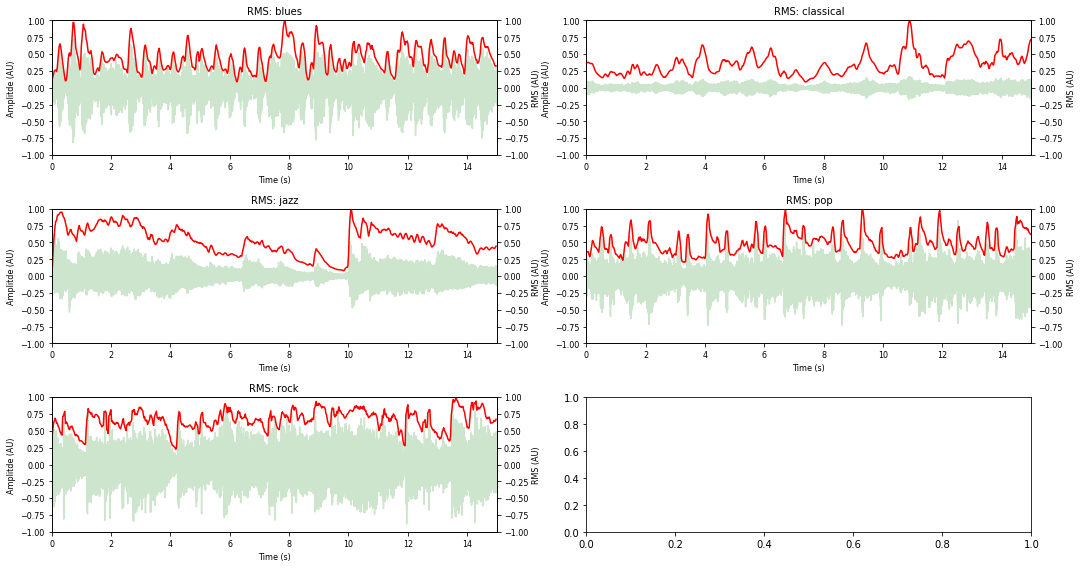

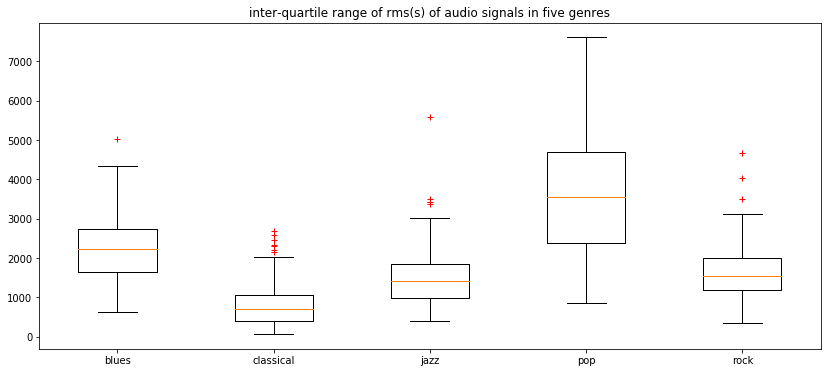

In [5]:
plots.plot_superimprose_wave(waveform, SoundFeature.RMS,15)
plots.plot_iqr(df, genres, SoundFeature.RMS)

**3) Spectrum Centroid - SC**:

Diferentemente das features anteriores, esta é um feature baseada na frequência, que indica onde o “centro de massa” do espectro está localizado e na prática costuma ser usado como medida do timbre musical.

Por ser uma medida no campo da frequência, acaba não sendo possível visualizá-la de forma fácil apenas com os gráficos de onda da música, principalmente quando as frequências são altas. Isto será visto mais adiante, mas por hora vamos considerar que precisamos melhorar a forma de capturar informações que estão "escondidas" no domínio da frequência. Para superar esta dificuldade de conseguir informação de tempo no domínio da frequência nós podemos utilizar a técnica chamada Short Time Fourier Transform, ou STFT. O STFT divide a música em janelas curtas (na ordem de milissegundos) e, em seguida, aplica a transformada de Fourier de cada uma das janelas.

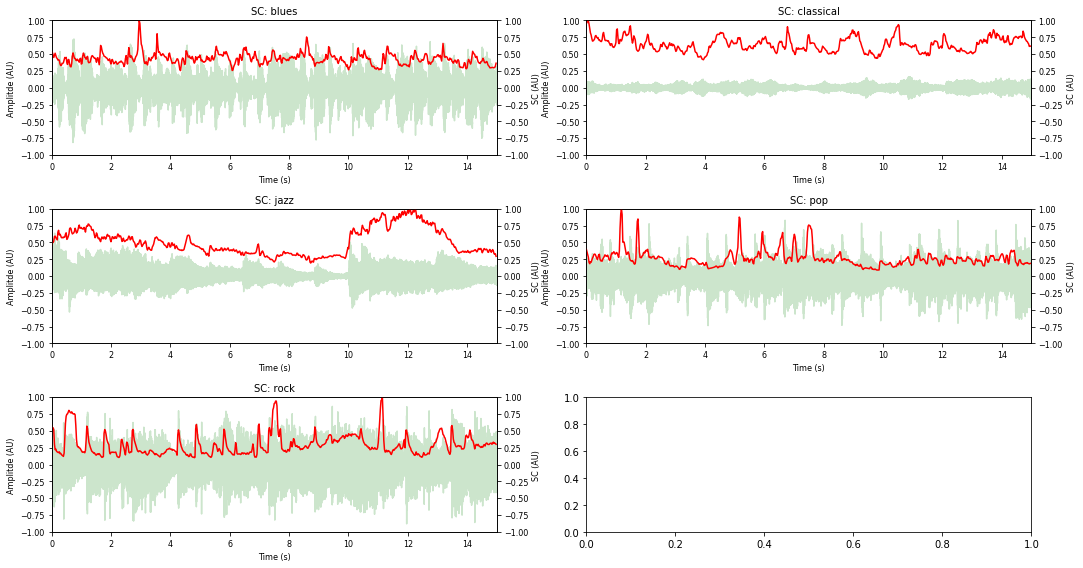

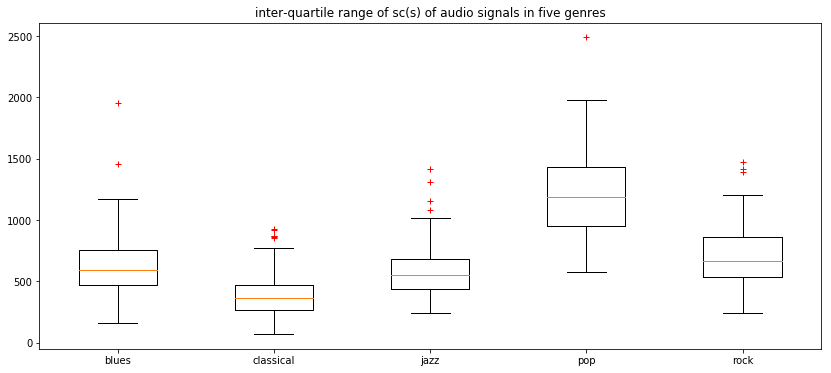

In [6]:
plots.plot_superimprose_wave(waveform, SoundFeature.SC,15)
plots.plot_iqr(df, genres, SoundFeature.SC)

Como esta é uma feature que está no domínio da frequência, podemos verificar através de espectrogramas como as frequências variam de acordo com instrumentos utilizados. Por exemplo, a canção 3.wav utilizada no gênero jazz, apresenta uma variação brusca no segundo 10, que coincide com o momento em que o saxofone toca notas altas. Já o espectrograma do gênero rock exibe vários picos de frequência ao longo da música, que corresponde a batida da bateria, e também por volta do segudo 10 há um aumento de frequência por alguns momentos, correspondendo a voz do cantor que é "estendida" na música. 

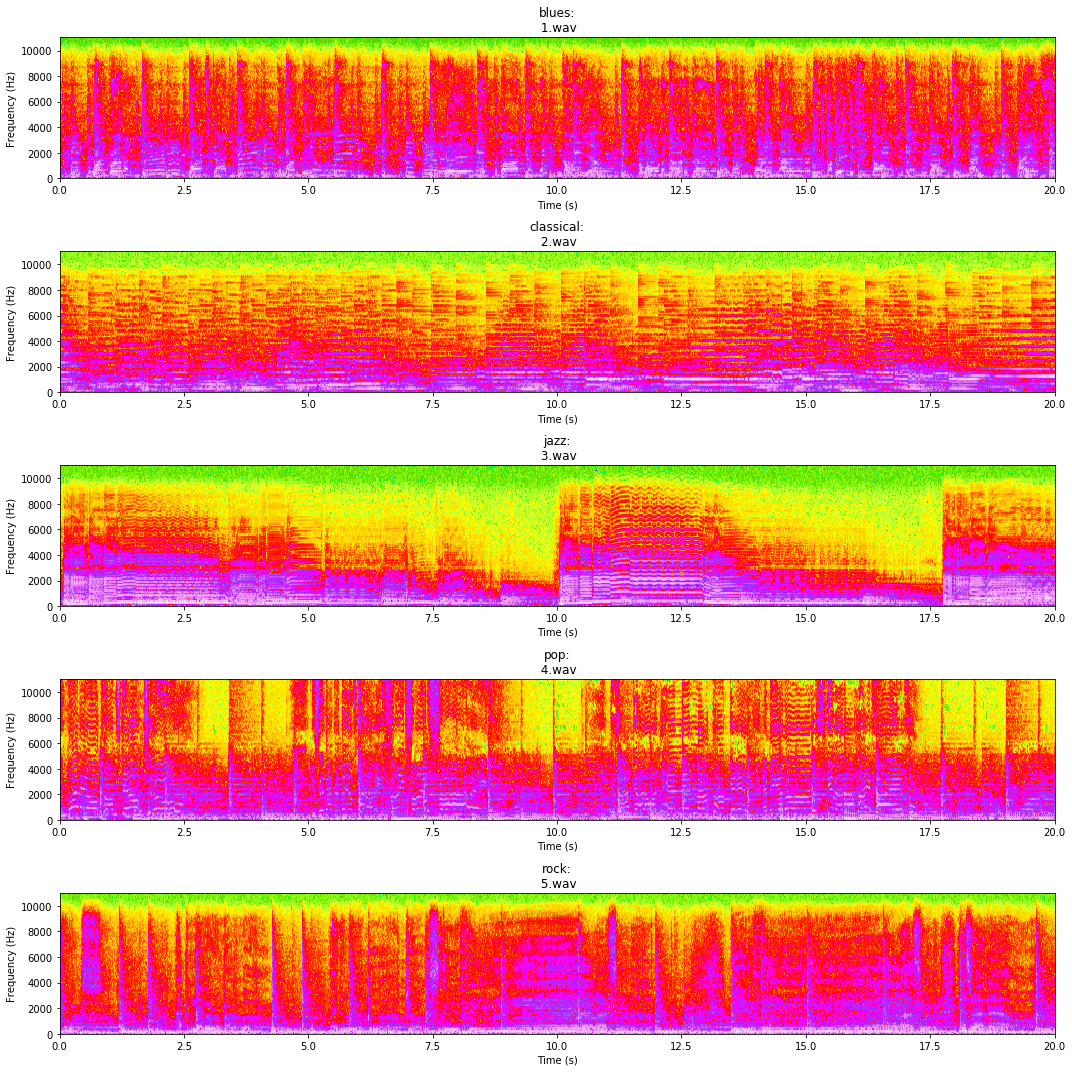

In [7]:
plots.plot_spectrograms(waveform, duration=20)

**4) Mel Frequency Cepstral Coefficients - MFCCs: Análise da Feature**: <br>
Esta é uma feature classificada como psicoacústica, ou seja, é baseada na percepção que o ser humano tem de perceber os sons. Essa percepção humana do sons varia com a frequência e é representado aqui através da Mel Scale Frequency, proposta por Stevens, Volkmann, and Newman em 1937[8]. Esta escala é baseada em um mapeamento entre frequência real e o "pitch" aparentemente percebido pelo ouvido humano. Em frequências baixas a escala é linear, porém conforme a frequência sobe o ouvido humano passa a ter mais dificuldade na percepção dos sons, ou seja, somos mais sensíveis às baixas frequências e menos sensíveis às altas frequências.

<br>

![Escala MEL](Mel-Hz_plot.svg.png)

Esta feature tem sido muito popular no campo do reconhecimento de fala. Neste trabalho não iremos nos aprofundar os mecanismo de extração dessa feature, uma vez que a biblioteca librosa faz esse trabalho. No entanto, o algoritmo básico de extração dessa feature é mostrado abaixo:

![MFCCS_FEATURE](mfccs.png)

Neste ponto iremos extrair 13 bandas MCFFs juntamente com seu valor delta, que representa a estimativa local da derivada dos dados de entrada ao longo tempo, em outras palavras, o delta representa a variação de coeficiente entre frames. Este valores são as divisões de bandas de frequência na escala Mel. Poderíamos dividir em mais ou menos bandas, no entanto, as bandas muito altas representam mudanças rápidas no banco de filtros MEL e degradam a performance ASR[9], por isso as desconsideramos.

### Benchmark

No estudo realizado por Seyerlehner et al[7], é mencionado pelo autor que até o momento somente um trabalho publicado trata de comparar a classificação musical realizada por humanos com a classificação realizada de forma automática por computadores. O trabalho que realizou esse experimento foi publicado por Tzanetakis et al [1]. Neste estudo foram classificadas 190 músicas em 19 diferentes categorias. A classificação humana apresentou acurácia entre 26% e 71%, com uma média de 55%. Para o nosso trabalho iremos considerar um objetivo de 70% já que iremos trabalhar com um conjunto reduzido de apenas 5 gêneros musicais.

## III. Metodologia

### Pré-processamento de dados

Como mencionado anteriormente, iremos trabalhar com 4 features distintas. Do domínio do tempo temos Zero-Crossing Rate e a Root Mean Square, do domínio da frequência temos a Spectral Centroid e do domínio espectral mas filtrados em Mel Frequency Banks, que são bancos de atributos divididos na escala de frequência Mel, a feature Mel Frequency Cepstral Coefficients. 

A extração das features é realizada pela biblioteca librosa, através da funções *zero_crossing_rate, rmse, spectral_centroid e mfcc*. Este valores são armazenados em um dataframe para o posterior uso. Cada amostra contém 330.0750 valores (22050 Hz x 15 seg.).

A feature MFCC está sendo tratada como um banco de atributos da escala Mel, este banco está divido em treze bandas, então ela será desdobrada em treze features. 

Para combinar a informação de todos as bandas e coeficientes, nós iremos calcular suas médias e desvios padrões. Eliminaremos o MFCC do índice zero, pois não agrega informação. Assim teremos um total de 58 features (zcr std, zcr mean, rms std, rms mean, sc std, sc mean, 12 x MFCCs std e 12 x MFCCs mean, 12 x MFCCs delta std e 12 x MFCCs delta mean) mais a categoria do gênero musical. 


In [6]:
features, labels, X, y = npdata.prepare_data(df)

Após a extração das features, podemos visualizar a correlação entre elas.

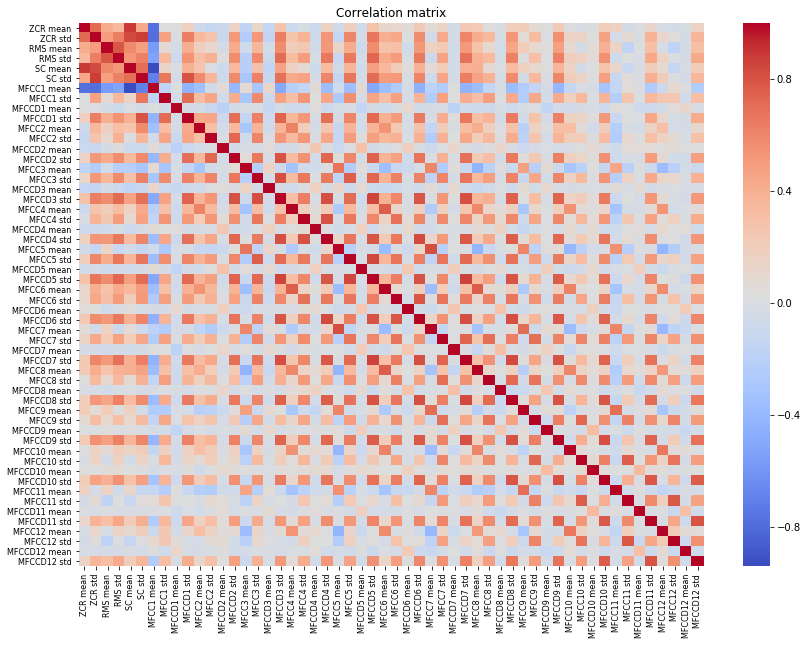

In [7]:

title='Correlation matrix'

plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), annot=False, cmap=plt.cm.coolwarm)
plt.yticks(rotation=0, fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.title(title)
plt.savefig('corr_matrix.png')


Podemos notar que as features ZCR, RMS e SC são bem correlacionadas entre si, enquanto as features MFCCs exibem correlações variadas.

### Implementação

Uma vez que temos as features extraídas e pré-processadas, iremos de fato submeter nossos dados ao modelo de treinamento. Para isto usaremos o k-NN.

K-NN é modelo de aprendizagem baseado em instâncias para classificar diferentes classes de
dados. A ideia do KNN é descobrir qual classe tem mais pontos próximos aos dados do teste. Escolhe
um k específico que significa encontrar k vizinhos. Ele simplesmente armazena os dados e o rótulo
memória e uma vez se peça para classificar uma instância particular, calcula a distância (com
função de distância específica) a todos os pontos nos dados de treinamento e atribui um rótulo
de acordo com o rótulo dos vizinhos K mais próximos. A razão para escolha deste algoritmo é sua simplicidade e por ser bem conhecido no uso de  reconhecimento de padrões, para uso em problemas de classificação
supervisionada. No entanto, por ser sensível aos dados, ele requer um bom conjunto de
features para que possa performar de forma satisfatória, e para isso precisaremos fazer
alguma normalização dos dados antes do treinamento. Antes de utilizá-lo ainda precisamos normalizar os dados


In [9]:
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler

scaler = StandardScaler()
X_normal = scaler.fit_transform(X)
X_normal = pd.DataFrame(X_normal, columns=X.columns)


#### Detecção de valores atípicos (Outlier)

Para evitar que dados discrepantes possam enviesar os resultados, aplicamos o Método Turco para identificar outliers: Um passo do discrepante é calculado 1,5 vezes a variação interquartil (IQR). Um ponto de dados com um atributo que está além de um passo de um discrepante do IQR para aquele atributo, ele será considerado anormal. E removeremos os outliers que estiverem duplicados em mais de uma features

In [18]:

import itertools

outliers_lst = []

for feature in X_normal.keys():
    
    Q1 = np.percentile(X_normal[feature], 25)    
    Q3 = np.percentile(X_normal[feature], 75)
    
    step = 1.5 * (Q3-Q1)
    
    r_outlier = X_normal[~((X_normal[feature] >= Q1 - step) & (X_normal[feature] <= Q3 + step))]
    
    outliers_lst.append(list(r_outlier.index))
        
outliers = list(itertools.chain.from_iterable(outliers_lst))

uniq_outliers = list(set(outliers))    

print( 'Unique list:\n', uniq_outliers)

X_normal = X_normal.drop(X_normal.index[uniq_outliers]).reset_index(drop = True)
y = y.drop(y.index[uniq_outliers]).reset_index(drop = True)

Unique list:
 [1, 6, 9, 12, 31, 45, 47, 59, 70, 74, 92, 97, 99, 102, 103, 114, 115, 116, 117, 118, 124, 125, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 143, 144, 145, 147, 150, 152, 153, 154, 156, 157, 159, 160, 164, 166, 167, 168, 172, 176, 177, 178, 180, 184, 186, 192, 194, 199, 204, 208, 209, 212, 215, 216, 217, 220, 224, 225, 227, 233, 236, 239, 240, 242, 243, 247, 252, 260, 262, 264, 265, 266, 267, 268, 272, 273, 275, 278, 279, 280, 282, 283, 284, 288, 289, 290, 291, 293, 298, 299, 302, 304, 305, 310, 313, 314, 316, 317, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331, 334, 338, 341, 342, 344, 345, 346, 351, 352, 354, 355, 357, 360, 361, 362, 363, 365, 366, 367, 368, 370, 373, 376, 380, 382, 383, 386, 387, 389, 390, 392, 393, 394, 395, 396, 400, 406, 408, 410, 432, 433, 435, 440, 446, 452, 453, 454, 459, 465, 467, 469, 472, 476, 486, 488, 489, 494, 495]


### k-Nearest Neighbors

Uma vez que os dados tenham sido normalizados, iremos dividí-los em conjunto de treinamento e teste. Porém alguns problemas de classificação podem exibir um grande desequilíbrio na distribuição das classes-alvo: por exemplo, pode haver várias vezes mais amostras negativas do que amostras positivas. Nesses casos, recomenda-se usar amostragem estratificada, e para isso, o sklearn implementa a função StratifiedShuffleSplit, assim garantimos que as frequências de classe relativas sejam aproximadamente preservadas.



In [92]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4)
accuracies = []
for train_index, test_index in sss.split(X_normal, y):
    X_train, X_test = X_normal.iloc[train_index], X_normal.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(X_train, y_train)

    y_preds = classifier.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_preds))

print(f'Acurácia média: {np.round(np.mean(accuracies),3):.2%}')


Acurácia média: 73.30%


O valor médio obtido para a acurácia foi de 73,30%. Neste treinamento usamos k igual a 1, no entanto, podemos tentar melhorar esse percentual manipulando alguns parâmetros do k-NN.

### Refinamento

A fim de tentar melhorar a performance do nosso algoritmo, iremos aplicar a técnica conhecida como GridSearch que para o nosso caso consistirá em aplicar o k-NN repetidas vezes utilizando diferentes valores para k. Para isso, precisamos especificar quais valores de k queremos, também iremos especificar outros dois parâmetros:

*weights*: quando temos distribuições de classe distorcidas pode-se usar uma votação ponderada. A classe de cada um dos vizinhos K é multiplicada por um peso proporcional ao inverso da distância desse ponto ao ponto de teste dado. Isso garante que os vizinhos mais próximos contribuam mais para a votação final do que os mais distantes. No sklearn isso é feito especificando esse parâmetro para "distance". Já o parâmetro com o valor "uninform" faz o k-NN ter o comportamento padrão

*p*: este parâmetro especifica que tipo de métrica de distância será tomada pelo algoritimo. No sklearn, utilizaremos o *manhattan_distance* e o *euclidean_distance*

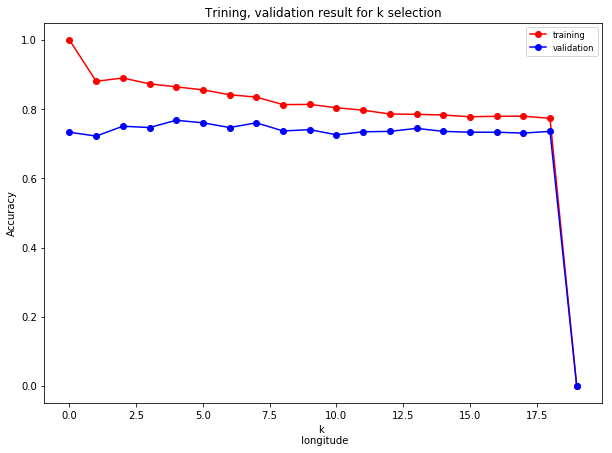

In [30]:
k=20

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4)
accuracies = []

result_test=np.zeros(k)
result_train=np.zeros(k)

for k1 in range(1, k):
    acc_train=0
    acc_test=0
    for train_index, test_index in sss.split(X_normal, y):
        X_train, X_test = X_normal.iloc[train_index], X_normal.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier = KNeighborsClassifier(n_neighbors=k1)
        classifier.fit(X_train, y_train)

        y_pred_train=classifier.predict(X_train)
        y_pred_test=classifier.predict(X_test)

        acc_train+=accuracy_score(y_train,y_pred_train)
        acc_test+=accuracy_score(y_test,y_pred_test)

    result_train[k1-1]=acc_train/10
    result_test[k1-1]=acc_test/10

fig,ax=plt.subplots(figsize=(10,7))
plt.plot(result_train,'ro-',label='training')
plt.plot(result_test,'bo-',label='validation')
plt.ylabel('Accuracy')
plt.title('Trining, validation result for k selection')
plt.xlabel('k \n longitude')
ax.legend(loc='best', prop={'size':'small'})



In [19]:
parameters = {'n_neighbors':np.arange(1,10,1),
              'weights':['uniform','distance'],
              'p':[1,2]}

X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size=0.25, random_state=0)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4, )


grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=sss, scoring='accuracy')
grid.fit(X_train, y_train)

print(f'Best score {grid.best_score_:.2%}')
print(f'Best params: {grid.best_params_}')

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

Best score 78.52%
Best params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
             precision    recall  f1-score   support

      blues       0.73      0.57      0.64        14
  classical       0.88      0.83      0.86        18
       jazz       0.39      0.58      0.47        12
        pop       0.83      0.91      0.87        11
       rock       0.61      0.54      0.57        26

avg / total       0.69      0.67      0.67        81



Após a aplicação do GridSearchCV, conseguimos obter o valor de k=3 o melhor resultado, elevando a pontuação para 78,52% de acurácia. O gráfico acima exibe o comportamento do treinamento e teste ao variar o valor de k.

### Bagging

Após a extração das features chegamos a um número significativo de dimensões, portanto iremos utilizar o método de random subspaces aliado ao Knn, isto é, vários modelos de Knn, cada um treinado num subconjunto dos dados. Pra conseguirmos isto, utlizaremos o Bagging do sklearn, onde controlaremos o max_features  e utilizaremos o knn como o 'base_estimator' do Bagging.

In [13]:
from sklearn.ensemble import BaggingClassifier

knn = KNeighborsClassifier()
bagging = BaggingClassifier(knn, max_samples=0.75, max_features=.5)

bagging_score = cross_val_score(bagging, X_normal, y, cv=10, n_jobs=-1, scoring='accuracy').mean()
print(f'Bagging Score: {bagging_score:.2%}')

Bagging Score: 79.40%


## IV. Resultados

### Modelo de avaliação e validação

Como pode ser observado, através do GridSearch conseguimos melhorar a performance para 79,40% acurácia média com base nos melhores parâmetros sugerido pelo GridSearch. Ainda para efeitos de estudo, treinamos o algoritmo com os melhores valores sugeridos pelo GridSearch e mantendo o n_split = 1. Utilizando a matriz de confusão  podemos observar os acertos, falsos positivos, falsos negativos. Na matriz os valores vão de zero vinte e cinco, pois  tínhamos 100 arquivos de música por gênero musical e reservamos 25% deles para o dataset de teste apenas. Ainda, o valor de k que apresentou melhor acurácia no treinamento do modelo foi k=3.

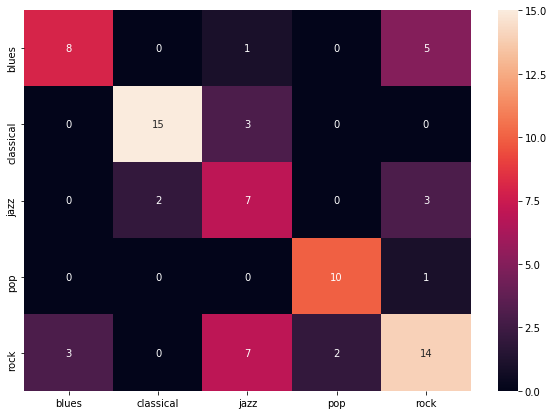

In [98]:
conf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(conf_matrix, index=genres,columns=genres)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('knn_cm.png')


### Justificativa

O modelo parece ter atingido as expectativas, uma vez que o objetivo que foi estabelecido era pelo menos um valor de 70% de acurácia. Analisando a matriz de confusão podemos ver que todos os gêneros musicais tiveram taxas de acerto muito próximas. Podemos notar também que rock e blues algumas vezes foram dados como falsos positivos entre eles. Um dos motivos que pode levar a isto é a origem do rock, que foi fortemente baseada nos ritmos do blues. Músicas como pop e rock sempre incorporam aspectos de outros gêneros, o que torna difícil a distinção de certas músicas, tanto para computadores quanto para seres humanos. Assim acreditamos que para uma aplicação mais robusta, como na vida real, necessita-se de mais levantamentos e estudo a respeito do som e suas features.

## V. Conclusão

### Foma livre de visualização

Uma vez que o k-NN é um classificador baseado em distância podemos criar uma matriz de distância para entender melhor o comportamento das amostras. Cada ponto no gráfico representa a distância de uma amostra que está em cada um dos eixos, e quanto mais claro o ponto, maior é a distância entre as features. A linha diagonal preta corresponde a distância zero.  

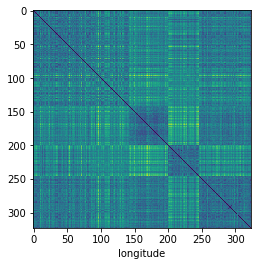

In [103]:
from sklearn.metrics.pairwise import pairwise_distances

min_max_scaler = MinMaxScaler()
f_new = min_max_scaler.fit_transform(X_normal)

d=pairwise_distances(f_new)

d=d/np.max(d)
d=d.astype('float32')
plt.figure()
plt.imshow(d)

plt.xlabel('longitude')

plt.show()

### Reflexão

Este projeto foi desafiador porque eu nunca havia trabalhado no campo da música, então tive que pesquisar bastante para entender o que é o som e como extrair features que realmente importavam. Há muito trabalhos informais nessa área (que não estão em revistas acadêmicas). Escolhi empregar o k-NN devido as caracteristicas do problema e também devido sua utilização em vários estudos similares. O projeto pode ser resumido em:
 - Coletar o aúdio: procurar um dataset publico bem conhecido e quem tenha sido utilizado em outros projetos para que possa servir de benchmark
 - Analisar a sua estrutura: analisar a estruta do dataset a fim de descobrir o comportamento das features
 - Pré processar os dados para facilitar a extração das features, e posteriormente extraílas
 - Contruir um modelo de treinamento, sendo que aqui é verificado quais os melhores parâmetros e algorítimos para maximizar a performance do modelo
 
### Melhorias

Este projeto limitou-se aos tipos de features mais usualmente tratadas em estudos de áudio, no entanto existem muitas outras features correlacionadas a sinais de áudios que poderiam ajudar na classificação de áudio. Também não realizamos testes com outro modelo, como por exemplo redes de neurais profundas, nem aplicamos PCA no estudo. 

### Referências

[1] G. Tzanetakis and P. Cook. Musical genre classifica on of audio signals. IEEE
Transac ons on Speech andmAudio Processing, (Volume: 10, Issue: 5, Jul 2002)
h ps://ieeexplore.ieee.org/document/1021072/

[2] Repositório do dataset h p://opihi.cs.uvic.ca/sound/genres.tar.gz

[3] S. Lippens, J.-P. Martens, T. D. Mulder, et al., “A Comparison of Human and
Automa c Musical Genre Classifica on,” in Proceedings of the Interna onal Conference
on Acous cs, Speech, and Signal Processing (ICASSP), Montreal, 2004

[4] ZCR https://en.wikipedia.org/wiki/Zero-crossing_rate

[5] STE http://iitg.vlab.co.in/?sub=59&brch=164&sim=857&cnt=1

[6] LibRosa python lib https://librosa.github.io/librosa/core.html

[7] Klaus Seyerlehner, Gerhard Widmer and Peter Knees - A Comparison of Human, Automatic and Collaborative Music Genre Classification and User Centric Evaluation of Genre Classification Systems - Dept. of Computational Perception, Johannes Kepler University, Linz, Austria.

[8] S. S. Stevens1, J. Volkmann1, and E. B. Newman -A Scale for the Measurement of the Psychological Magnitude Pitch J. Acoust. Soc. Am. Volume 8, Issue 3, pp. 185-190 (1937); (6 pages)

[9] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/